In [1]:
###Made by Khalil Droubi
###To process Iolite baseline-subtracted NP-II files for BB

To Do:
-Test out Error minimization

In [2]:
import pandas as pd
import os
import re
import copy
import numpy as np
from scipy import stats
from scipy.stats import linregress

#Graphing stuff
from matplotlib import pyplot as plt
%matplotlib inline

# %pip install seaborn
# import seaborn as sns

%pip install PyPDF2
from PyPDF2 import PdfFileMerger, PdfFileReader

#pd.set_option("display.precision", 8)

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Functions
def read_np2_timeseries(excel_file):
    ''' Excel input file is your baseline corrected time series export from Iolite for the NP-II.'''
    df = pd.read_excel(excel_file, sheet_name = None)
    keys = df.keys()
    header_row = 0
    new_dict = {}
    for key in keys:
        if '.' in key: #Kind of hard-coded right now, so if names get weird may need to change
            df_test = df[key]

            df_test.columns = df_test.iloc[header_row]
            df_test = df_test.drop(header_row)
            df_test = df_test.reset_index(drop=True)
            
            test1_new = df_test[['Absolute Time',
             'Elapsed Time',
                 'm238_CPS',
                 'm232_CPS',
                 'm208_CPS',
                 'm207_CPS',
                 'm206_CPS',
                 'm204_CPS',
                 'm202_CPS',]]
            
            new_dict[key] = test1_new
    return new_dict

def calc_CPS(np2_dict):
    columns = ['Absolute Time',
     'Elapsed Time',
     'm238_CPS',
     'm232_CPS',
     'm208_CPS',
     'm207_CPS',
     'm206_CPS',
     'm204_CPS',
     'm202_CPS']

    new_col = ['Absolute Time',
     'Elapsed Time',
     '238_CPS',
     '232_CPS',
     '208_CPS',
     '207_CPS',
     '206_CPS',
     '204_CPS',
     '202_CPS']

    cut_col = ['238_CPS',
     '232_CPS',
     '208_CPS',
     '207_CPS',
     '206_CPS',
     '204_CPS',
     '202_CPS']

    calc_dict = {}
    for key in np2_dict:
        #print(key)
        test_df1 = np2_dict[key]

        for col in columns:
                test_df2 = test_df1.apply(lambda x: x * 62500000 if 'CPS' in x.name else x)
        test_df2.columns = new_col
        test_df2 = test_df2[cut_col]
        result = pd.concat([test_df1, test_df2], axis=1)
        
        result['206/238'] = result.apply(lambda x: x['206_CPS']/x['238_CPS'], axis=1)
        result['208/232'] = result.apply(lambda x: x['208_CPS']/x['232_CPS'], axis=1)
        result['207/206'] = result.apply(lambda x: x['207_CPS']/x['206_CPS'], axis=1)
        result['208/206'] = result.apply(lambda x: x['208_CPS']/x['206_CPS'], axis=1)
        result['206/204'] = result.apply(lambda x: x['206_CPS']/x['204_CPS'], axis=1)
        
        calc_dict[key] = result
    
    return calc_dict

def statistics_NP2(calc_dict):
    calc_list = ['238_CPS', '232_CPS',
           '208_CPS', '207_CPS', '206_CPS', '204_CPS', '202_CPS', '206/238',
           '208/232', '207/206', '208/206', '206/204']
    mega_dict = {}

    for sheet in calc_dict:
        tester = calc_dict[sheet]
        stats_dict = {}
        for col in tester:

            if col in calc_list:
                #print(col)
                df_mean = tester[col].mean()
                stats_dict[col + '_mean'] = df_mean
                df_precision = (2 * tester[col].sem()) / df_mean * 100
                stats_dict[col + '_precision'] = df_precision
        stats_dict['Time (s)'] = tester['Elapsed Time'].max()
        
        new_string = sheet.replace('time series data', '')
        mega_dict[new_string] = stats_dict

    df_1 = pd.DataFrame(mega_dict)
    df_flip = pd.DataFrame.transpose(df_1)
    return df_flip

def files_process_toEXCEL(calc_dict, excel_name):
    with pd.ExcelWriter(excel_name) as writer:
        for sheet in calc_dict:
            calc_dict[sheet].to_excel(writer, sheet_name = sheet, index = False)
        
        statistics_NP2(calc_dict).to_excel(writer, sheet_name = 'Statistics', index = True)

def file_process_combine(filename):
    calc_dict = calc_CPS(read_np2_timeseries(filename))
    new_filename = str(filename.split('.')[0]) + '_processed.xlsx'
    files_process_toEXCEL(calc_dict, new_filename)

In [4]:
filename = '0416_glass_SS_NPII_baseline.xlsx'

In [5]:
calc_dict = calc_CPS(read_np2_timeseries(filename))

In [6]:
calc_dict.keys()

dict_keys(['GDE-1G 1.1 time series data', 'GDE-1G 1.2 time series data', 'GDE-1G 1.3 time series data', 'GDE-1G 1.4 time series data', 'GDE-1G 1.5 time series data', 'SRM NIST 610 1.1 time series da', 'SRM NIST 610 1.2 time series da', 'SRM NIST 610 1.3 time series da', 'SRM NIST 610 1.4 time series da', 'SRM NIST 610 1.5 time series da', 'SRM NIST 610 1.6 time series da', 'SRM NIST 610 1.7 time series da', 'SRM NIST 610 1.8 time series da', 'SRM NIST 610 1.9 time series da', 'SRM NIST 610 1.10 time series d', 'SRM NIST 610 1.11 time series d', 'SRM NIST 610 1.12 time series d', 'SRM NIST 610 1.13 time series d', 'SRM NIST 610 1.14 time series d', 'SRM NIST 610 1.15 time series d', 'BHVO-2G 1.1 time series data', 'BHVO-2G 1.2 time series data', 'BHVO-2G 1.3 time series data', 'BHVO-2G 1.4 time series data', 'BHVO-2G 1.5 time series data', 'BCR-2G 1.1 time series data', 'BCR-2G 1.2 time series data', 'BCR-2G 1.3 time series data', 'BCR-2G 1.4 time series data', 'BCR-2G 1.5 time series d

Plot for  GDE-1G 1.1  is complete.


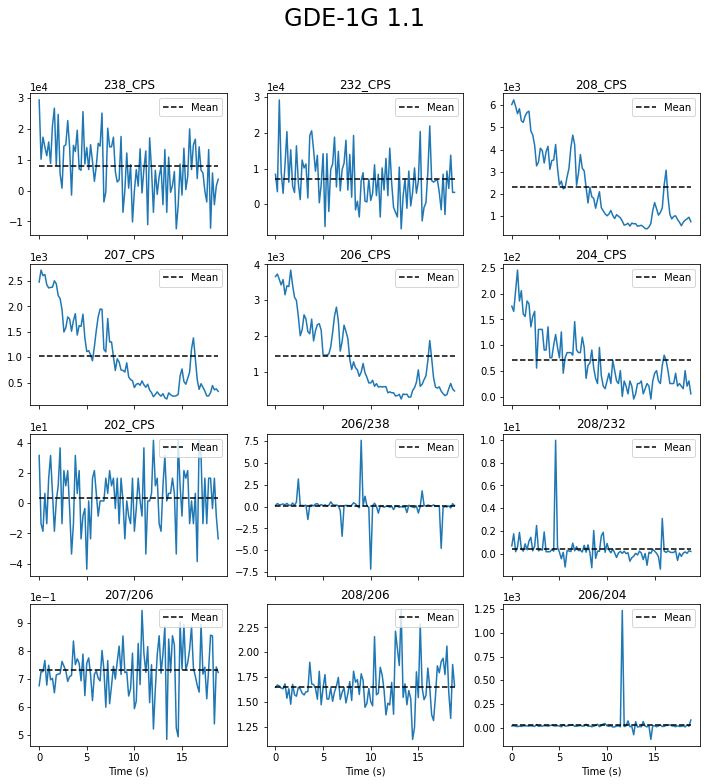

In [24]:
def U_Pb_plots(calc_dict, sample, choice = True):
    key_list = ['238_CPS', '232_CPS',
       '208_CPS', '207_CPS', '206_CPS', '204_CPS', '202_CPS', '206/238',
       '208/232', '207/206', '208/206', '206/204']
    
    zet = calc_dict[sample]
    new_string = sample.split('time')[0].rstrip()
    y_list = []
    for key in key_list:
        y_list.append(zet[key])
    
    x = zet['Elapsed Time']
    
    fig, axs = plt.subplots(4, 3, sharex = True, figsize = (12, 12))
    fig.suptitle(new_string, fontsize=24)
    
    ax_list = [
        axs[0, 0], 
        axs[0, 1],   
        axs[0, 2], 
        axs[1, 0], 
        axs[1, 1],
        axs[1, 2],
        axs[2, 0], 
        axs[2, 1], 
        axs[2, 2],
        axs[3, 0], 
        axs[3, 1], 
        axs[3, 2]   
        ]

    axs[0, 0].plot(x, y_list[0])
    axs[0, 1].plot(x, y_list[1])
    axs[0, 2].plot(x, y_list[2])
    axs[1, 0].plot(x, y_list[3])
    axs[1, 1].plot(x, y_list[4])
    axs[1, 2].plot(x, y_list[5])
    axs[2, 0].plot(x, y_list[6])
    axs[2, 1].plot(x, y_list[7])
    axs[2, 2].plot(x, y_list[8])
    axs[3, 0].plot(x, y_list[9])
    axs[3, 0].set(xlabel = 'Time (s)')
    axs[3, 1].plot(x, y_list[10])
    axs[3, 1].set(xlabel = 'Time (s)')
    axs[3, 2].plot(x, y_list[11])
    axs[3, 2].set(xlabel = 'Time (s)')
    for idx in range(len(ax_list)):
        ax_list[idx].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_list[idx].set_title(key_list[idx])
        y_mean = [np.mean(y_list[idx])]*len(x)
        # Plot the average line
        mean_line = ax_list[idx].plot(x,y_mean, label='Mean', linestyle='--', color = "black")
        # Make a legend
        legend = ax_list[idx].legend(loc='upper right')
    
    MYDIR = ("Figures")
    CHECK_FOLDER = os.path.isdir(MYDIR)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        #print("created folder : ", MYDIR)
    
    #new_string = sample.replace('time series data', '').rstrip()
    
    filename = os.path.join(MYDIR, new_string + '.pdf')
    plt.savefig(filename)
    print('Plot for ', new_string, " is complete.")
    
    if choice == False:
        plt.close()
    #else:
        #plt.close()

U_Pb_plots(calc_dict, 'GDE-1G 1.1 time series data')

In [25]:
MYDIR = ("Figures")
mergedObject = PdfFileMerger()
file_list = []
keys = calc_dict.keys()

for key in keys:
    #print(key)
    
    U_Pb_plots(calc_dict, key, False)
    new_string = key.split('time')[0].rstrip()
    filename = os.path.join(MYDIR, new_string + '.pdf')
    
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
    
mergedObject.write("U-Pb_output.pdf")  

Plot for  GDE-1G 1.1  is complete.
Plot for  GDE-1G 1.2  is complete.
Plot for  GDE-1G 1.3  is complete.
Plot for  GDE-1G 1.4  is complete.
Plot for  GDE-1G 1.5  is complete.
Plot for  SRM NIST 610 1.1  is complete.
Plot for  SRM NIST 610 1.2  is complete.
Plot for  SRM NIST 610 1.3  is complete.
Plot for  SRM NIST 610 1.4  is complete.
Plot for  SRM NIST 610 1.5  is complete.
Plot for  SRM NIST 610 1.6  is complete.
Plot for  SRM NIST 610 1.7  is complete.
Plot for  SRM NIST 610 1.8  is complete.
Plot for  SRM NIST 610 1.9  is complete.
Plot for  SRM NIST 610 1.10  is complete.
Plot for  SRM NIST 610 1.11  is complete.
Plot for  SRM NIST 610 1.12  is complete.
Plot for  SRM NIST 610 1.13  is complete.
Plot for  SRM NIST 610 1.14  is complete.
Plot for  SRM NIST 610 1.15  is complete.
Plot for  BHVO-2G 1.1  is complete.
Plot for  BHVO-2G 1.2  is complete.
Plot for  BHVO-2G 1.3  is complete.
Plot for  BHVO-2G 1.4  is complete.
Plot for  BHVO-2G 1.5  is complete.
Plot for  BCR-2G 1.1  is